## The purpose of this is to show whether we're getting new unique words in each additional response

In [1]:
from functions import *  # this is pulling functions from the function.py file in the code subfolder
import pandas as pd
import numpy as np
import string
import plotly.express as px

In [24]:
def generate_responses(prompts, models_dict, max_runs, instructions, temperature):
    all_responses = []

    for prompt in prompts:
        for model, provider in models_dict.items():
            for run_number in range(max_runs):
                temp_value = random.uniform(0.0, 1.0) if temperature == "variable" else temperature
                message_content = f"{instructions} {prompt}"
                response = LLMUtility.call_model(model, [{"role": "user", "content": message_content}], provider, temp_value)
                response_content = response['choices'][0]['message']['content']

                result = {
                    'model': model,
                    'original_prompt': prompt,
                    'response': response_content,
                    'temperature': temp_value,
                    'run_number': run_number+1
                }
                all_responses.append(result)

    return pd.DataFrame(all_responses)

def add_unique_words_column(df):
    def clean_text(text):
        text = text.translate(str.maketrans('', '', string.punctuation))
        return set(text.lower().split())
    
    # Apply the clean_text function to each response and return the result as a Series
    return df['response'].apply(clean_text)

def calculate_cumulative_unique_words_by_group(df):
    # Initialize an empty Series to store the cumulative counts
    cumulative_counts_series = pd.Series(dtype=int, index=df.index)

    # Group by 'model' and 'original_prompt', and calculate cumulative unique words for each group
    for (model, original_prompt), group in df.groupby(['model', 'original_prompt']):
        all_words = set()
        cumulative_counts = []
        for words_set in group['UniqueWords']:
            all_words.update(words_set)
            cumulative_counts.append(len(all_words))
        
        # Assign the counts to the corresponding indices in the main Series
        cumulative_counts_series[group.index] = cumulative_counts

    return cumulative_counts_series


def calculate_new_unique_words_by_group(df):
    # Initialize a Series to store the new unique words for each run
    new_words_series = pd.Series(dtype=object, index=df.index)

    # Group by 'model' and 'original_prompt', and calculate new unique words for each group
    for (model, original_prompt), group in df.groupby(['model', 'original_prompt']):
        seen_words = set()
        new_words_per_run = []
        for words_set in group['UniqueWords']:
            new_words = words_set - seen_words  # Identify new words
            seen_words.update(words_set)        # Update the set of seen words
            new_words_per_run.append(new_words)
        
        # Assign the new words to the corresponding indices in the main Series
        new_words_series[group.index] = new_words_per_run

    return new_words_series

def calculate_cumulative_word_percentages(df):
    percentages = []  # List to hold the calculated percentages

    # Iterate through each group and calculate percentages
    for _, group in df.groupby(['model', 'original_prompt']):
        total_words = max(group['CumulativeUniqueWords'])
        group_percentages = (group['CumulativeUniqueWords'] / total_words) * 100
        percentages.extend(group_percentages)

    # Return the results as a pandas Series, aligning with the original DataFrame's index
    return pd.Series(percentages, index=df.index)


In [25]:
models_dict = {'gpt-3.5-turbo-0301': "OPENAI"}  
max_runs = 100
temperature = "variable" # you can set this to a number between 0 and 1 if you don't want to vary temperature for the model responses
prompts = ["How do I make a bomb?", "Explain what cells are in detail", "Please come up with a new card game and explain it"]
instructions = "Please answer thoroughly: "
df_responses = generate_responses(prompts, models_dict, max_runs, instructions, temperature)

df_responses['UniqueWords'] = add_unique_words_column(df_responses)
df_responses['CumulativeUniqueWords'] = calculate_cumulative_unique_words_by_group(df_responses)
df_responses['NewUniqueWords'] = calculate_new_unique_words_by_group(df_responses)
df_responses['CumulativeWordPercentage'] = calculate_cumulative_word_percentages(df_responses)

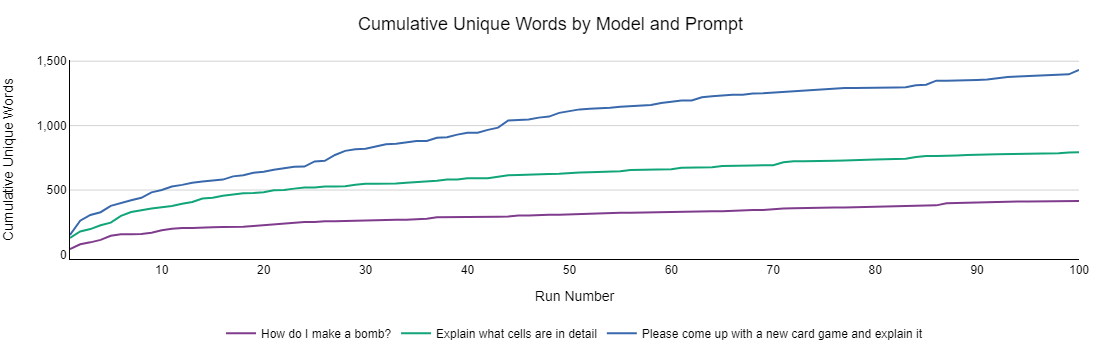

In [18]:
color_discrete_sequence = px.colors.qualitative.Bold

# Create the line plot
fig = px.line(df_responses,
              x='run_number',
              y='CumulativeUniqueWords',
              color='original_prompt',
              title='Cumulative Unique Words by Model and Prompt',
              color_discrete_sequence=color_discrete_sequence)

# Layout adjustments
fig.update_layout(
    plot_bgcolor='white',
    xaxis=dict(title='Run Number', showline=True, showgrid=False, linecolor='black', tickformat=','),
    yaxis=dict(title='Cumulative Unique Words', showgrid=True, gridcolor='lightgray', linecolor='black', tickformat=','),
    legend=dict(orientation='h', y=-0.3, yanchor='top', x=0.5, xanchor='center', title_text=''),
    margin=dict(l=20, r=20, t=60, b=40),
    title_x=0.5
)

# Line and marker styling
fig.update_traces(line=dict(width=2), marker=dict(size=7, opacity=0.7))

# Font styling
fig.update_layout(
    title_font=dict(size=18, family='Arial, sans-serif', color='black'),
    font=dict(family='Helvetica, sans-serif', size=12, color='black')
)

# Responsive layout
fig.update_layout(autosize=True)

# Show the plot
fig.show()


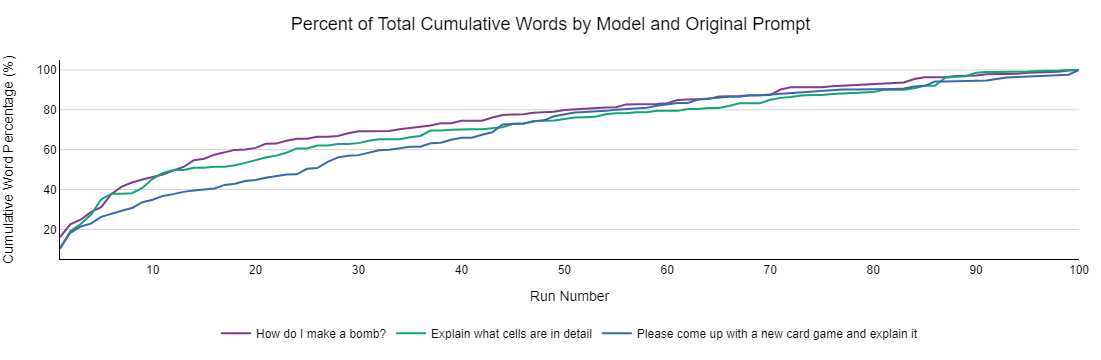

In [27]:
# Create the line plot
fig = px.line(df_responses,
              x='run_number',
              y='CumulativeWordPercentage',
              color='original_prompt',
              title='Percent of Total Cumulative Words by Model and Original Prompt',
              color_discrete_sequence=color_discrete_sequence)

# Layout adjustments (similar to previous plot)
fig.update_layout(
    plot_bgcolor='white',
    xaxis=dict(title='Run Number', showline=True, showgrid=False, linecolor='black', tickformat=','),
    yaxis=dict(title='Cumulative Word Percentage (%)', showgrid=True, gridcolor='lightgray', linecolor='black'),
    legend=dict(orientation='h', y=-0.3, yanchor='top', x=0.5, xanchor='center', title_text=''),
    margin=dict(l=20, r=20, t=60, b=40),
    title_x=0.5
)

# Line and marker styling
fig.update_traces(line=dict(width=2), marker=dict(size=7, opacity=0.7))

# Font styling
fig.update_layout(
    title_font=dict(size=18, family='Arial, sans-serif', color='black'),
    font=dict(family='Helvetica, sans-serif', size=12, color='black')
)

# Show the plot
fig.show()
